# NLP PROJECT: SPAM LINK DETECTION SYSTEM

#### Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import regex as re
import matplotlib.pyplot as plt

In [44]:
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer

In [5]:
from wordcloud import WordCloud

In [6]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/vscode/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [7]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/vscode/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [8]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /home/vscode/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [9]:
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /home/vscode/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

### Step 1. Reading the data set

In [10]:
url = 'https://raw.githubusercontent.com/4GeeksAcademy/NLP-project-tutorial/main/url_spam.csv'
data = pd.read_csv(url)
data.head()

,url,is_spam
0,https://briefingday.us8.list-manage.com/unsubs...,True
1,https://www.hvper.com/,True
2,https://briefingday.com/m/v4n3i4f3,True
3,https://briefingday.com/n/20200618/m#commentform,False
4,https://briefingday.com/fan,True


### Step 2: Data processing

In [11]:
print(f'The DataFrame contains {len(data)} records (rows) and {len(data.columns)} variables (columns).')

The DataFrame contains 2999 records (rows) and 2 variables (columns).


#### Categorical to numerical transformation

In [12]:
data['is_spam'] = data['is_spam'].map({False: 0, True: 1})
data.head()

,url,is_spam
0,https://briefingday.us8.list-manage.com/unsubs...,1
1,https://www.hvper.com/,1
2,https://briefingday.com/m/v4n3i4f3,1
3,https://briefingday.com/n/20200618/m#commentform,0
4,https://briefingday.com/fan,1


#### Elimination of repeated values

In [13]:
data_c = data.drop_duplicates() # Return DataFrame with duplicate rows removed.
data_c.shape

(2369, 2)

In [14]:
print(f'True:  {len(data_c.loc[data_c.is_spam == 0])}')
print(f'False: {len(data_c.loc[data_c.is_spam == 1])}')

True:  2125
False: 244


In [15]:
data_c=data_c.reindex(['is_spam', 'url'], axis=1)

#### Text processing

In [16]:
def preprocess_text(text):
    # Remove any character that is not a letter (a-z) or white space ( )
    text = re.sub(r'[^a-z ]', " ", text)
    
    # Remove white spaces
    text = re.sub(r'\s+[a-zA-Z]\s+', " ", text)
    text = re.sub(r'\^[a-zA-Z]\s+', " ", text)

    # Multiple white spaces into one
    text = re.sub(r'\s+', " ", text.lower())

    # Remove tags
    text = re.sub("&lt;/?.*?&gt;"," &lt;&gt; ", text)

    return text.split()

In [17]:
data_c["url"] = data_c["url"].apply(preprocess_text)
data_c.head()

,is_spam,url
0,1,"[https, briefingday, us, list, manage, com, un..."
1,1,"[https, www, hvper, com]"
2,1,"[https, briefingday, com, v, i]"
3,0,"[https, briefingday, com, m, commentform]"
4,1,"[https, briefingday, com, fan]"


#### Lemmatization of the text

In [19]:
lemmatizer = WordNetLemmatizer()

stop_words = stopwords.words("english")

def lemmatize_text(words, lemmatizer = lemmatizer):
    tokens = [lemmatizer.lemmatize(word) for word in words]
    tokens = [word for word in tokens if word not in stop_words]
    tokens = [word for word in tokens if len(word) > 3]
    return tokens

In [20]:
data_c["Clean_text"] = data_c["url"].apply(lemmatize_text)
data_c.head()

,is_spam,url,Clean_text
0,1,"[https, briefingday, us, list, manage, com, un...","[http, briefingday, list, manage, unsubscribe]"
1,1,"[https, www, hvper, com]","[http, hvper]"
2,1,"[https, briefingday, com, v, i]","[http, briefingday]"
3,0,"[https, briefingday, com, m, commentform]","[http, briefingday, commentform]"
4,1,"[https, briefingday, com, fan]","[http, briefingday]"


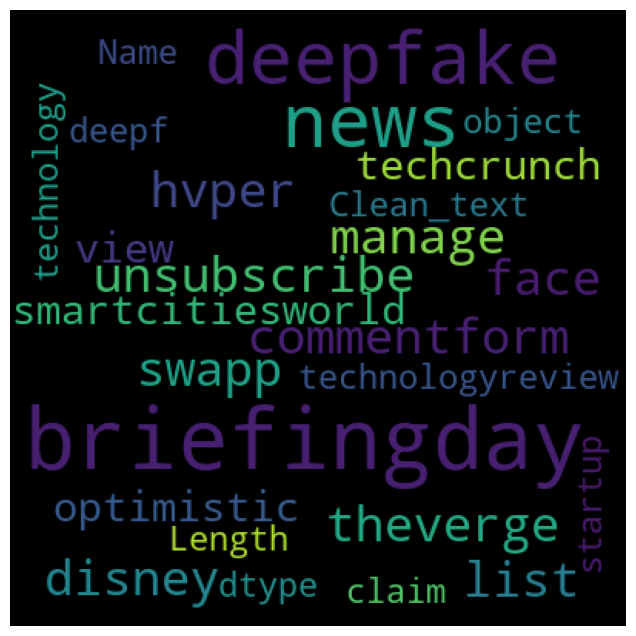

In [ ]:
wordcloud = WordCloud(width = 400, height = 400, background_color = "black", max_words = 1000, min_font_size = 20, random_state = 42)\
    .generate(str(data_c["Clean_text"]))

fig = plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

#### Divide the dataset into train and test: X_train, X_test, y_train, y_test

In [83]:
tokens_list = data_c["Clean_text"]
tokens_list = [" ".join(tokens) for tokens in tokens_list]

In [87]:
vectorizer = TfidfVectorizer(max_features = 5000, max_df = 0.8, min_df = 5)
X = vectorizer.fit_transform(tokens_list).toarray()
y = data_c["is_spam"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

### Step 3: Build an SVM

In [88]:
model_svm = SVC(kernel = "linear", random_state = 42)
model_svm.fit(X_train, y_train)
y_pred_svc = model_svm.predict(X_test)

In [89]:
accuracy_score(y_test, y_pred_svc)

0.9514767932489452

#### Using the naive bayes model

In [90]:
model_nb = MultinomialNB()
model_nb.fit(X_train, y_train)
y_pred_nb = model_nb.predict(X_test)

In [91]:
accuracy_score(y_test, y_pred_nb)

0.9493670886075949

### Step 4: Optimize the previous model

In [74]:
hyperparams = {
    "C"     : [0.1, 1, 10],
    "kernel": ["linear", "poly", "rbf"],
    "degree": [1, 2, 3],
    "gamma" : ["scale", "auto"]
}

# We initialize the random search
grid = GridSearchCV(model_svm, hyperparams, scoring = "accuracy", cv = 5)
grid

GridSearchCV(cv=5, estimator=SVC(kernel='linear', random_state=42),
             param_grid={'C': [0.1, 1, 10], 'degree': [1, 2, 3],
                         'gamma': ['scale', 'auto'],
                         'kernel': ['linear', 'poly', 'rbf']},
             scoring='accuracy')

In [75]:
grid.fit(X_train, y_train)
print(f"Best hyperparameters: {grid.best_params_}")

Best hyperparameters: {'C': 10, 'degree': 1, 'gamma': 'scale', 'kernel': 'rbf'}


In [92]:
opt_model = SVC(C = 10, degree = 1, gamma = "scale", kernel = "rbf", random_state = 42)
opt_model.fit(X_train, y_train)
y_pred = opt_model.predict(X_test)
accuracy_score(y_test, y_pred)

0.9578059071729957

### Step 5: Save the model

In [ ]:
from pickle import dump

dump(model_svm, open("NLP_model_svm_classifier_C-10_deg-1_gam-scale_ker-rbf_42.sav", "wb"))